In [1]:
import pyam
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib.transforms as mtransforms

from pathlib import Path

<IPython.core.display.Javascript object>

Step 1: Read in the data prepared in the notebook `101_prepare_input_data.ipynb`.

In [2]:
df = pyam.IamDataFrame(
    Path(
        '../data/101_data.xlsx'
    )
)

pyam - INFO: Running in a notebook, setting up a basic logging at level INFO
pyam.core - INFO: Reading file ../data/101_data.xlsx
pyam.core - INFO: Reading meta indicators


Step 2: Prepare the data for panel a. For this panel, we basically need the data for the following variables:
* 

In [3]:
variables = [
    'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Gross',
    'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land|Direct',
    'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Non-Land'
]

In [4]:
panel_a_part_1 = (
    df
    .filter(
        variable=variables[0],
        region='World'
    )
)

In [5]:
variables[1:3]

['AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land|Direct',
 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Non-Land']

In [6]:
panel_a_part_2 = (
    df
    .filter(
        variable=variables[1:3],
        region='World'
    )
    .convert_unit(
        current='Gt CO2/yr',
        to='Gt CO2/yr',
        factor=-1
    )
)

In [7]:
panel_a = pyam.concat(
    [
        panel_a_part_1,
        panel_a_part_2
    ]
)

In [8]:
panel_a_offset = (
    panel_a
    .filter(
        year=range(2020, 2101)
    )
    .offset(year=2020)
)

Step 3: Now let us construct a version of this data that also is a % of the total mitigation effort.

In [9]:
total_mitigation = (
    df
    .filter(
        variable='AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Direct Only',
        year=[2020, 2100],
        region='World'
    )
    .timeseries()
    .reset_index()
    .drop(
        columns=[
            'variable',
            'region',
            'unit'
        ]
    )
    .set_index(['model', 'scenario'])
)

In [10]:
total_mitigation_diff = total_mitigation.diff(axis=1).dropna(axis=1)

In [11]:
panel_a_percent = pyam.IamDataFrame(
    panel_a_offset
    .timeseries()
    .apply(
        lambda x: x * 100/ total_mitigation_diff.loc[x.name[0:2],2100],
        axis=1
    )
)

In [12]:
panel_a_percent.meta = df.meta
panel_a_offset.meta = df.meta

Step 4: Let us start some plotting

In [13]:
categories_and_colors = {
    'C1':'#4dbdab',
    'C2':'#7688ab',
    'C3':'#e74d4d'
}

In [14]:
panel_a_percent.variable

['AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land|Direct',
 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Non-Land',
 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Gross']

In [15]:
df.meta.rename(
    columns={
        'Median peak warming (MAGICCv7.5.3)':'median_peak_warming'
    },
    inplace=True
)

In [16]:
df.meta.loc[:, 't_decline'] = df.meta.loc[:, 'median_peak_warming'] - df.meta.loc[:, 'Median warming in 2100 (MAGICCv7.5.3)']

In [17]:
df.meta.loc[:, 'archetype'] = df.meta.Policy_category.apply(
    lambda x: 'Immediate' if ('P2' in x or 'P0' in x) else 'Delayed'
)

In [18]:
df.meta.columns

Index(['Category', 'Category_name', 'Category_subset',
       'Category_Vetting_historical', 'IMP_marker',
       'Literature Reference (if applicable)', 'Policy_category',
       'Policy_category_name', 'Project_study', 'CO2 emissions 2030 Gt CO2/yr',
       ...
       'Interpolated Net-Zero Year for AR6 Reanalysis|OSCARv3.2|Emissions|CO2',
       'category_new_rolling_mean', 'cumulative_cdr_netzero_2100',
       'cdr_net_zero', 'gross_net_zero', 'cumulative_gross_netzero_2100',
       'land_cdr_2020_netzero', 'novel_cdr_2020_netzero', 't_decline',
       'archetype'],
      dtype='object', length=103)

We should assign the two policy archetypes - delay and immediate

In [19]:
font = {'size'   : 15}
plt.rc('font', **font)

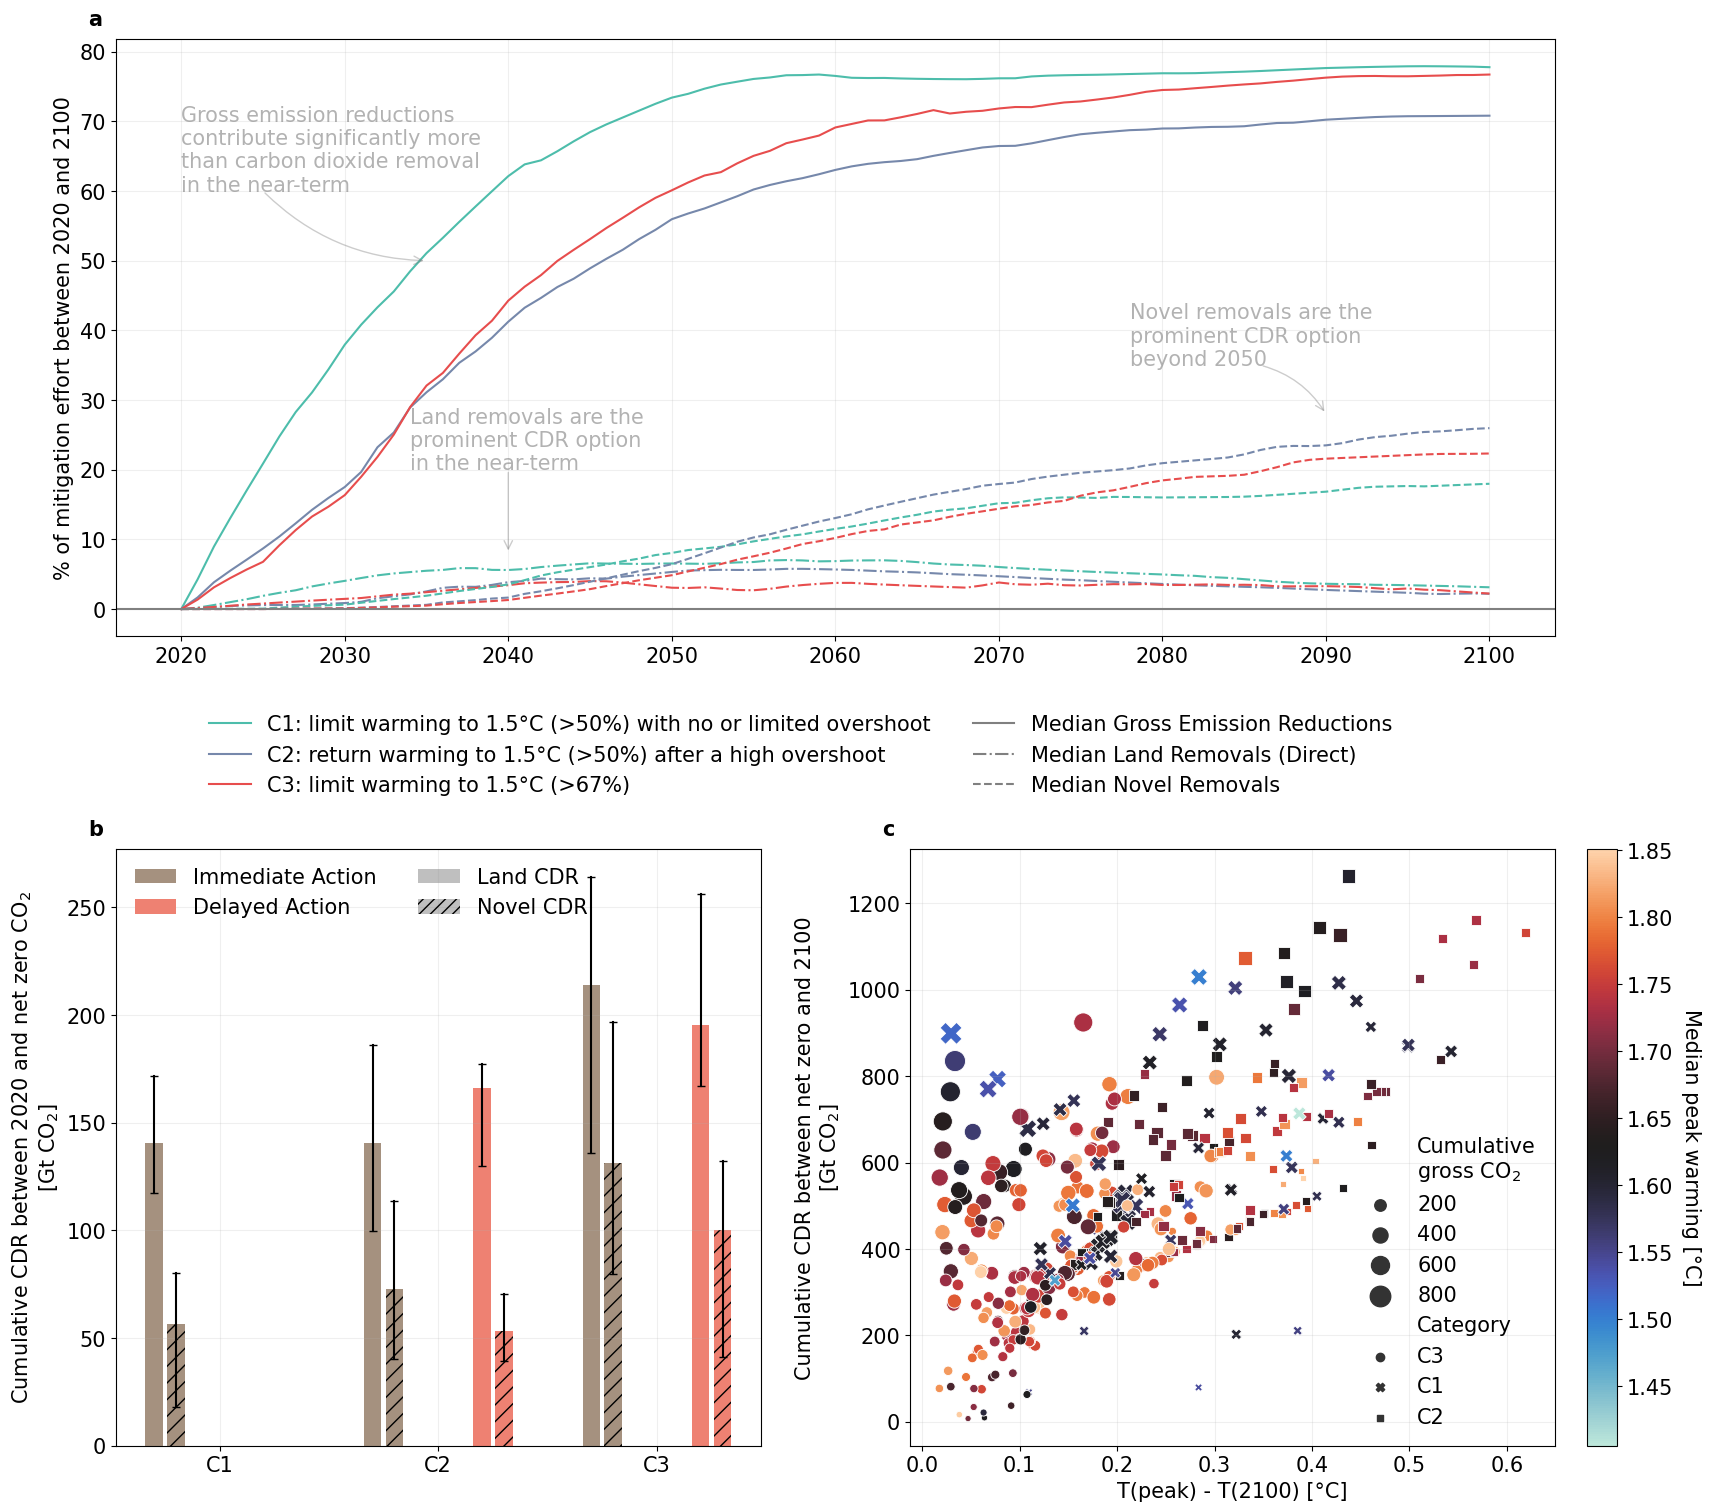

In [20]:
fig, ax = plt.subplot_mosaic(
    [
        ['a', 'a'],
        ['b', 'c']
    ],
    figsize=(17,15),
    constrained_layout=True
)

# Panel a: Median across the three variables
# Then we will include annotations to guide the reader
variables_and_linestyles = {
    'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land|Direct':'dashdot',
    'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Non-Land':'dashed',
    'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Gross':'solid'    
}

for var in variables_and_linestyles.keys():
    for category in categories_and_colors.keys():
        _plot_data = (
            panel_a_percent
            .filter(
                variable=var,
                Category=category
            )
            #.convert_unit(
            #    current='Gt CO2/yr',
            #    to='Gt CO2/yr',
            #    factor=-1
            #)
            .timeseries()
            .median()
        )
        ax['a'].plot(
            _plot_data.index,
            _plot_data,
            color=categories_and_colors[category],
            linestyle=variables_and_linestyles[var]
        )
ax['a'].text(
    x=2020,
    y=60,
    s='Gross emission reductions\ncontribute significantly more\nthan carbon dioxide removal\nin the near-term',
    fontdict={
        'color':'grey',
        'alpha':0.6,
        'fontsize':15
    }
)

ax['a'].annotate(
    text='',
    xy=(2035, 50),
    xycoords='data',
    xytext=(2025, 60),
    textcoords='data',
    arrowprops={'arrowstyle':'->', 'connectionstyle':'arc3,rad=0.2', 'color':'grey', 'alpha':0.4}
)

ax['a'].text(
    x=2034,
    y=20,
    s='Land removals are the\nprominent CDR option\nin the near-term',
    fontdict={
        'color':'grey',
        'alpha':0.6,
        'fontsize':15
    }
)

ax['a'].annotate(
    text='',
    xy=(2040, 8),
    xycoords='data',
    xytext=(2040, 20),
    textcoords='data',
    arrowprops={'arrowstyle':'->', 'color':'grey', 'alpha':0.4}
)

ax['a'].text(
    x=2078,
    y=35,
    s='Novel removals are the\nprominent CDR option\nbeyond 2050',
    fontdict={
        'color':'grey',
        'alpha':0.6,
        'fontsize':15
    }
)

ax['a'].annotate(
    text='',
    xy=(2090, 28),
    xycoords='data',
    xytext=(2086, 35),
    textcoords='data',
    arrowprops={'arrowstyle':'->', 'connectionstyle':'arc3,rad=-0.2', 'color':'grey', 'alpha':0.4}
)
ax['a'].axhline(0, color='grey')
ax['a'].set_ylabel('% of mitigation effort between 2020 and 2100')

# Panel b - Cumulative removals until net zero (land and otherwise)
for i, cat in enumerate(['C1', 'C2', 'C3']):
    plot = df.meta[df.meta['Category']==cat]
    for arch in ['Immediate', 'Delayed']:
        plot_data = plot[plot['archetype']==arch]
        if arch=='Immediate':
            x1 = i-0.3
            x2 = i-0.2
            color='#a5917f'
        else:
            x1 = i+0.2
            x2 = i+0.3
            color='#ee8172'
        ax['b'].bar(
            x=x1,
            height=plot_data['land_cdr_2020_netzero'].median(),
            width=0.08,
            color=color
        )
        ax['b'].errorbar(
            x=[x1, x1],
            y=[
                plot_data['land_cdr_2020_netzero'].quantile(q=0.25),
                plot_data['land_cdr_2020_netzero'].quantile(q=0.75)
            ],
            marker='_',
            color='black'
        )
        ax['b'].bar(
            x=x2,
            height=plot_data['novel_cdr_2020_netzero'].median(),
            width=0.08,
            hatch='//',
            color=color
        )
        ax['b'].errorbar(
            x=[x2, x2],
            y=[
                plot_data['novel_cdr_2020_netzero'].quantile(q=0.25),
                plot_data['novel_cdr_2020_netzero'].quantile(q=0.75)
            ],
            marker='_',
            color='black'
        )

ax['b'].set_xticks([0,1,2])
ax['b'].set_xticklabels(['C1', 'C2', 'C3'])

custom_legend_panel_b = [
    Patch(facecolor='#a5917f', label='Immediate Action'),
    Patch(facecolor='#ee8172', label='Delayed Action'),
    Patch(facecolor='grey', label='Land CDR', alpha=0.5),
    Patch(facecolor='grey', hatch='///', label='Novel CDR', alpha=0.5),
]
ax['b'].legend(handles=custom_legend_panel_b, ncol=2, framealpha=0.0,)
ax['b'].set_ylabel('Cumulative CDR between 2020 and net zero CO$_2$\n[Gt CO$_2$]')

# Panel c - scatter
c = sns.scatterplot(
    x='t_decline',
    y='cumulative_cdr_netzero_2100',
    style='Category',
    ax=ax['c'],
    data=df.meta,
    size='cumulative_gross_netzero_2100',
    hue='median_peak_warming',
    palette='icefire',
    sizes=(20, 250)
)

#Colormap
norm = plt.Normalize(
    df.meta['median_peak_warming'].min(),
    df.meta['median_peak_warming'].max()
)
sm = plt.cm.ScalarMappable(cmap="icefire", norm=norm)

cbar = c.figure.colorbar(sm, ax=ax['c'])
cbar.ax.set_ylabel('Median peak warming [°C]', rotation=270, labelpad=20) 

ax['c'].set_xlabel('T(peak) - T(2100) [°C]')
ax['c'].set_ylabel('Cumulative CDR between net zero and 2100\n[Gt CO$_2$]')
h, l = c.get_legend_handles_labels()
l[7] = 'Cumulative\ngross CO$_2$'
ax['c'].legend(h[7:], l[7:], ncol=1, framealpha=0.0, loc=4)
#ax['c'].legend.get_frame().set_facecolor('none')


# Add a custom legend for this graph
custom_legend = [
   # Line2D([0], [0], color='w', label='Panel a'),
    Line2D([0], [0], color=categories_and_colors['C1'], label='C1: limit warming to 1.5°C (>50%) with no or limited overshoot'),
    Line2D([0], [0], color=categories_and_colors['C2'], label='C2: return warming to 1.5°C (>50%) after a high overshoot'),
    Line2D([0], [0], color=categories_and_colors['C3'], label='C3: limit warming to 1.5°C (>67%)'),
    #Line2D([0], [0], color='w', label=''),
    Line2D([0], [0], color='grey', label='Median Gross Emission Reductions'),
    Line2D([0], [0], color='grey', linestyle='dashdot', label='Median Land Removals (Direct)'),
    Line2D([0], [0], color='grey', linestyle='dashed', label='Median Novel Removals'),
]
ax['a'].legend(handles=custom_legend,bbox_to_anchor=(0.9, -0.1),ncol=2, framealpha=0.0,)
## For panel a

for lab,a in ax.items():
    a.grid(alpha=0.2)
    trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
    a.text(0.0, 1.0, lab, transform=a.transAxes + trans,
             va='bottom', weight='bold')

In [21]:
fig.savefig(
    Path(
        'figures/fig1.png'
    ),
    dpi=400,
    bbox_inches='tight'
)

Statements
1. The gross CO2 emission contribution (maximum)

In [22]:
panel_a_percent.variable

['AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land|Direct',
 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Non-Land',
 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Gross']

In [23]:
max_gross_cont_c1 = (
    panel_a_percent
    .filter(
        variable='AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Gross',
        Category='C1'
    )
    .timeseries()
    .max(axis=1)
    .round(0)
)

In [24]:
print(
    f'Median {max_gross_cont_c1.median()}%, [{max_gross_cont_c1.quantile(q=0.25)}, {max_gross_cont_c1.quantile(q=0.75)} % interquartile range]'
)

Median 80.5%, [72.25, 93.75 % interquartile range]


In [25]:
max_gross_cont_c2 = (
    panel_a_percent
    .filter(
        variable='AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Gross',
        Category='C2'
    )
    .timeseries()
    .max(axis=1)
    .round(0)
)

In [26]:
print(
    f'Median {max_gross_cont_c2.median()}%, [{max_gross_cont_c2.quantile(q=0.25)}, {max_gross_cont_c2.quantile(q=0.75)} % interquartile range]'
)

Median 71.0%, [68.0, 77.75 % interquartile range]


2. Land-based removals

In [27]:
land_removals_c1 = (
    panel_a_percent
    .filter(
        variable='AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land|Direct',
        Category='C1'
    )
    .timeseries()
    .max(axis=1)
    .round(0)
)

In [28]:
print(
    f'Median {land_removals_c1.median()}%, [{land_removals_c1.quantile(q=0.25)}, {land_removals_c1.quantile(q=0.75)} % interquartile range]'
)

Median 8.0%, [6.0, 10.0 % interquartile range]


In [29]:
land_removals_c2 = (
    panel_a_percent
    .filter(
        variable='AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land|Direct',
        Category='C2'
    )
    .timeseries()
    .max(axis=1)
    .round(0)
)

In [30]:
print(
    f'Median {land_removals_c2.median()}%, [{land_removals_c2.quantile(q=0.25)}, {land_removals_c2.quantile(q=0.75)} % interquartile range]'
)

Median 6.0%, [3.0, 8.0 % interquartile range]


3. Novel removals

In [31]:
novel_removals_c1 = (
    panel_a_percent
    .filter(
        variable='AR6 Reanalysis|OSCARv3.2|Carbon Removal|Non-Land',
        Category='C1'
    )
    .timeseries()
    .max(axis=1)
    .round(0)
)

In [32]:
print(
    f'Median {novel_removals_c1.median()}%, [{novel_removals_c1.quantile(q=0.25)}, {novel_removals_c1.quantile(q=0.75)} % interquartile range]'
)

Median 18.5%, [15.0, 26.0 % interquartile range]
